# Simulating flow

With `bluebonnet.flow`, you can solve pseudopressure over time and calculate how production declines and recovery factor increases. First, a few imports:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

from bluebonnet.flow import (
    IdealReservoir,
    FlowProperties,
    FlowPropertiesTwoPhase,
    SinglePhaseReservoir,
    RelPermParams,
    relative_permeabilities,
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet import plotting

plt.style.use("ggplot")

In [2]:
def plot_pseudopressure(reservoir, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(0, 1, reservoir.nx)
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            ax.plot(x, p, color="steelblue")
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, 1), ylim=(0, 1.05))
    return fig, ax


def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale="squareroot", ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0, 1, 7) * np.sqrt(max(time))) ** 2, 1)
        ax.set_xticks(tick_locs)
    return ax

## Ideal gas simulation

Ideal gas follows $pV=nRT$, with density varying linearly with pressure (at constant temperature). This is modeled with `IdealReservoir`. Viscosity is treated as a constant with this class.

In [3]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

res_ideal = IdealReservoir(50, 1000, 9000, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()

CPU times: user 3.63 s, sys: 11.5 ms, total: 3.64 s
Wall time: 3.64 s


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

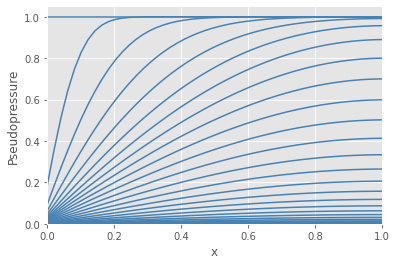

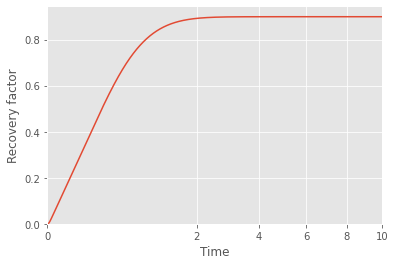

In [4]:
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")

## Real gas simulation

For real gases, the z-factor and viscosity can vary with pressure. Thus, density is not linear with pressure. For an example, see the PVT table stored in the tests folder:

<AxesSubplot:xlabel='pseudopressure', ylabel='diffusivity'>

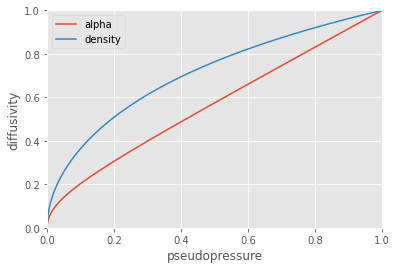

In [5]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv").rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)


def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: 1 / (x.compressibility * x.viscosity),
        density=lambda x: x.Density / max(x.Density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min())
        / (x["pseudopressure"].max() - x["pseudopressure"].min()),
    ).assign(alpha=lambda x: x.alpha / x.alpha.iloc[-1])[
        [
            "pressure",
            "pseudopressure",
            "alpha",
            "density",
            "z-factor",
            "compressibility",
            "viscosity",
        ]
    ]
    return out


fluid_properties = pvt_gas.pipe(scale_pressure_diffusivity)
ax = fluid_properties.plot(x="pseudopressure", y="alpha")
ax.set(ylim=(0, 1), xlim=(0, 1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density", ax=ax)

In a change from the ideal gas reservoir, we need to process the PVT table with `FlowProperties`, which becomes an argument passed to the `SinglePhaseReservoir` class. After that, simulating pseudopressure profiles and recovery factors are identical to the ideal reservoir case.

In [6]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

flow_properties = FlowProperties(fluid_properties, p_i=12_000)

res_realgas = SinglePhaseReservoir(50, 2000, 12000, flow_properties)

%time res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()

/usr/local/lib/python3.9/site-packages/bluebonnet/flow/flowproperties.py:87: UserWarning: WARNING!!! SCALING PSEUDOPRESSURE BY VALUE AT P_INITIAL
  warnings.warn("WARNING!!! SCALING PSEUDOPRESSURE BY VALUE AT P_INITIAL")


CPU times: user 6.16 s, sys: 17.2 ms, total: 6.17 s
Wall time: 6.17 s


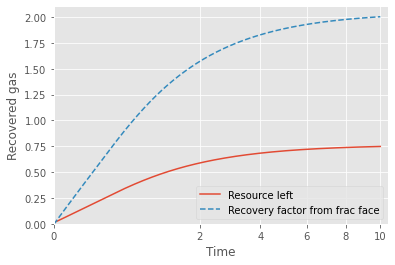

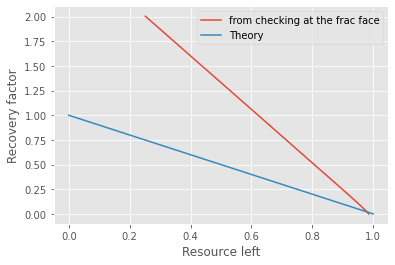

In [7]:
from scipy import interpolate

density_interp = interpolate.interp1d(
    flow_properties.pvt_props["m-scaled"], flow_properties.pvt_props["density"]
)


def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt["pseudopressure"], pvt["density"])
    return (density(pseudopressure)).sum(axis=1)


remaining_gas = (
    resource_left(res_realgas.pseudopressure, flow_properties.pvt_props)
    / res_realgas.nx
)
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gas, label="Resource left")
ax.plot(time, rf2, "--", label="Recovery factor from frac face")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovered gas",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
)

fig, ax = plt.subplots()
ax.plot(remaining_gas, rf2, label="from checking at the frac face")
ax.plot([1, 0], [0, 1], label="Theory")
ax.set(xlabel="Resource left", ylabel="Recovery factor")
ax.legend()

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

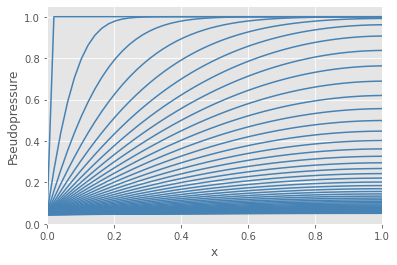

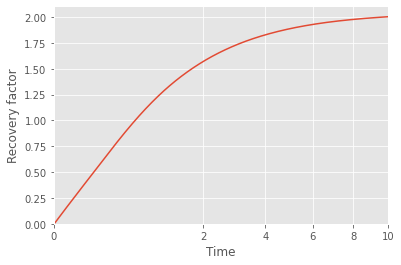

In [8]:
ax = plot_pseudopressure(res_realgas)

ax = plot_recovery_factor(res_realgas)
ax.set(xlabel="Time", ylabel="Recovery factor")

# Flow Curves

The recovery factor curves vary with fracture face pressure. Here, we run a series of simulations at different fracture face pressures and compare the resulting recovery factor.

In [9]:
p_i = 12000
rf = {}
for p_f in np.linspace(500, 2000, 7):
    print("Starting", p_f)
    fluid_properties = pvt_gas[pvt_gas.pressure >= p_f].pipe(scale_pressure_diffusivity)
    flow_properties = FlowProperties(fluid_properties, p_i=p_i)
    res_realgas = SinglePhaseReservoir(50, p_f, p_i, flow_properties)

    %time res_realgas.simulate(time)
    rf[f"{p_f:.0f}"] = res_realgas.recovery_factor()

Starting 500.0
CPU times: user 3.79 s, sys: 12.5 ms, total: 3.81 s
Wall time: 3.81 s
Starting 750.0
CPU times: user 4.01 s, sys: 10 ms, total: 4.02 s
Wall time: 4.02 s
Starting 1000.0
CPU times: user 3.83 s, sys: 10.8 ms, total: 3.84 s
Wall time: 3.84 s
Starting 1250.0
CPU times: user 4.05 s, sys: 8.64 ms, total: 4.06 s
Wall time: 4.06 s
Starting 1500.0
CPU times: user 3.91 s, sys: 9.68 ms, total: 3.92 s
Wall time: 3.92 s
Starting 1750.0
CPU times: user 4.18 s, sys: 14.7 ms, total: 4.2 s
Wall time: 4.2 s
Starting 2000.0
CPU times: user 4.08 s, sys: 14.9 ms, total: 4.09 s
Wall time: 4.1 s


[None]

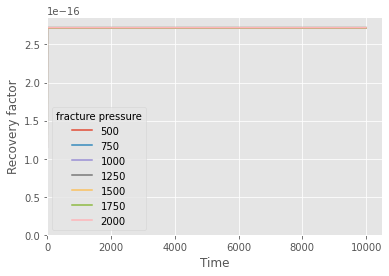

In [10]:
ax = pd.DataFrame(rf).plot()
ax.set(xlim=(0, None), ylim=(0, None), xlabel="Time", ylabel="Recovery factor")
ax.legend().set(title="fracture pressure")

Comparing the recovery factor for ideal versus real gases is enlightening. Because of the pressure variation of diffusivity, at real gas reservoirs assymptote more slowly than an ideal gas would.

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovery factor'),
 (0.0, 2.103882773066951),
 None,
 (0.0, 10.500000000000002)]

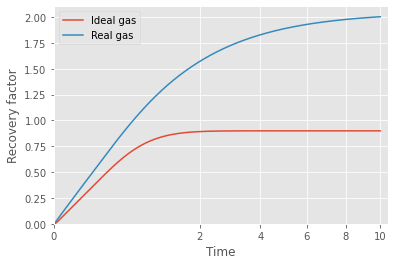

In [11]:
# ax = plot_pseudopressure(res_realgas)

fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovery factor",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
)

## Multiphase flow

The next level of complexity includes a gas phase that, at lower pressures, is no longer miscible with the oil phase. Water can also be present.

### Set up PVT

First we gather pvt data for the oil-gas system and water. Then we calculate the oil saturation as a function of pressure and perform the pseudopressure transform.

[(1000.0, 6000.0), (0.0, 1.0), Text(0, 0.5, 'Value')]

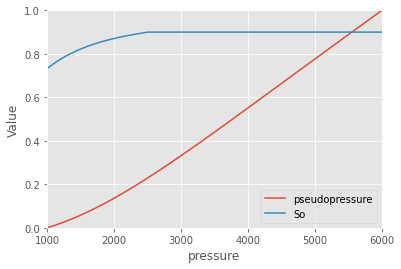

In [12]:
# set conditions
Sw = 0.1
p_frac = 1000
p_res = 6_000
phi = 0.1
fvf_scale = 1

# get pvt tables
pvt_oil = pd.read_csv("../tests/data/pvt_oil.csv")
pvt_water = pd.read_csv("../tests/data/pvt_water.csv").rename(
    columns={"T": "temperature", "P": "pressure", "Viscosity": "mu_w"}
)
df_pvt = (
    pvt_water.drop(columns=["temperature"])
    .merge(
        pvt_oil.rename(
            columns={
                "T": "temperature",
                "P": "pressure",
                "Oil_Viscosity": "mu_o",
                "Gas_Viscosity": "mu_g",
                "Rso": "Rs",
            }
        ),
        on="pressure",
    )
    .assign(Rv=0)
)

# calculate So, Sg assuming no mobile water
df_pvt_mp = df_pvt.copy()
df_pvt_mp["So"] = (1 - Sw) / (
    (df_pvt["Rs"].max() - df_pvt["Rs"]) * df_pvt["Bg"] / df_pvt["Bo"] / 5.61458 + 1
)

# scale pseudopressure
pseudopressure = interp1d(df_pvt.pressure, df_pvt.pseudopressure)
df_pvt_mp["pseudopressure"] = (
    pseudopressure(df_pvt_mp["pressure"]) - pseudopressure(p_frac)
) / (pseudopressure(p_res) - pseudopressure(p_frac))

fig, ax = plt.subplots()
df_pvt_mp.plot(x="pressure", y="pseudopressure", ax=ax)
df_pvt_mp.plot(x="pressure", y="So", ax=ax)
ax.set(xlim=(p_frac, p_res), ylim=(0, 1.0), ylabel="Value")

### Set up relative permeabilities

The next step involves declaring relative permeability curves. Here, we use the Brooks-Corey method, made available in this library with the `relative_permeabilities` function.

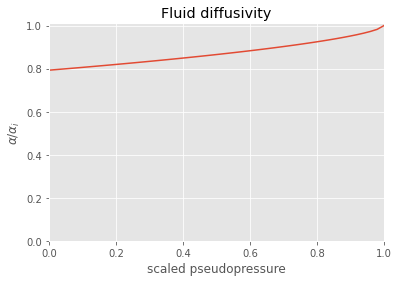

In [13]:
relperm_params = RelPermParams(
    n_o=1, n_g=1, n_w=1, S_or=0, S_gc=0, S_wc=0.1, k_ro_max=1, k_rw_max=1, k_rg_max=1
)
saturations_test = pd.DataFrame(
    {"So": np.linspace(0, 0.9), "Sw": np.full(50, 0.1), "Sg": np.linspace(0.9, 0)}
)
kr_matrix = pd.DataFrame(
    relative_permeabilities(saturations_test.to_records(index=False), relperm_params)
)
df_kr = pd.concat([saturations_test, kr_matrix], axis=1)
reference_densities = {"rho_o0": 141.5 / (45 + 131.5), "rho_g0": 1.03e-3, "rho_w0": 1}
flow_props = FlowPropertiesTwoPhase.from_table(
    df_pvt_mp, df_kr, reference_densities, phi, Sw, fvf_scale
)
m_scaled = np.linspace(0, 1)
fig, ax = plt.subplots()
ax.plot(m_scaled, flow_props.alpha(m_scaled) / flow_props.alpha(1))
ax.set(
    xlim=(0, 1),
    ylim=(0, None),
    xlabel="scaled pseudopressure",
    ylabel=r"$\alpha/\alpha_i$",
    title="Fluid diffusivity",
);

### Simulate

Calculating the pseudopressure profiles and recovery factor looks very similar to the functions used above. The main difference is a more complicated `flow_props` that came from `FlowPropertiesTwoPhase`.

In [14]:
res = SinglePhaseReservoir(50, p_frac, p_res, flow_props)
t_end = 3
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res.simulate(time)
rf = res.recovery_factor()

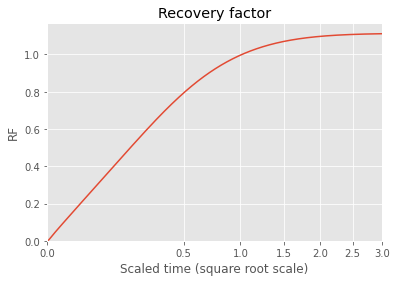

In [15]:
fig, ax = plt.subplots()
ax.plot(time, rf)
ax.set(
    xscale="squareroot",
    xlim=(0, t_end),
    ylim=(0, None),
    ylabel="RF",
    title="Recovery factor",
    xlabel="Scaled time (square root scale)",
);